### Homework 4


## Dataset preparation

For the rest of the homework, you'll need to use only these columns:

'age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y'



In [1]:
import pandas as pd

# Load the dataset from your local path
file_path = r'C:\Users\marti\Desktop\Machine_Learning\Zoomcamp\bank-full.csv'
df = pd.read_csv(file_path, delimiter=';')

# Show the first few rows of the dataset
df.head()




,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [2]:

import pandas as pd
from sklearn.metrics import roc_auc_score


# Select relevant columns and clean the data
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 
           'contact', 'day', 'month', 'duration', 'campaign', 
           'pdays', 'previous', 'poutcome', 'y']
df = df[columns]

# Convert 'y' to binary format (yes=1, no=0)
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Check for NaN values in the target column and numerical features
print(df.isnull().sum())  # Check for NaNs in all columns

# Optionally, you can drop rows with NaN values
df.dropna(inplace=True)



age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


## Question 1: ROC AUC Feature Importance

In [4]:

# Split the dataset into train/validation/test sets (60%/20%/20%)
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Now proceed to compute AUC for numerical variables
numerical = ['balance', 'day', 'duration', 'previous']  # Select the numerical variables
auc_scores = {}

# Calculate AUC for each numerical variable
for col in numerical:
    auc = roc_auc_score(df_train['y'], df_train[col])
    auc_scores[col] = auc if auc >= 0.5 else 1 - auc  # Invert if AUC < 0.5

print(auc_scores)  # Print the AUC scores for each numerical variable



{'balance': np.float64(0.5888313805382317), 'day': np.float64(0.525957882383908), 'duration': np.float64(0.8147002759670778), 'previous': np.float64(0.5985653242764153)}


## Question 2: Training the Model

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Convert the dataset into dictionaries
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

# Apply one-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train['y'])

# Predict probabilities and calculate AUC
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(df_val['y'], y_pred)
auc


np.float64(1.0)

## Question 3: Precision and Recall Curves

c:\Users\marti\Desktop\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


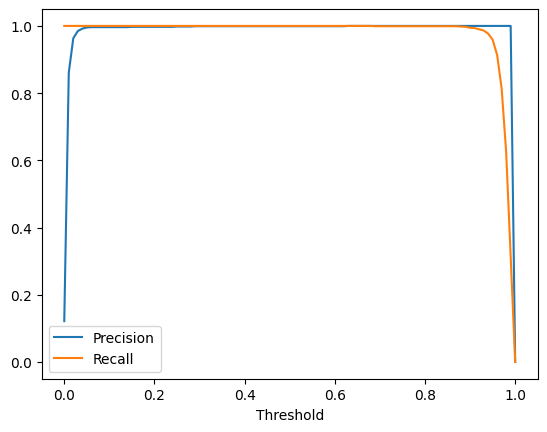

In [6]:
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_class = (y_pred >= t).astype(int)
    precisions.append(precision_score(df_val['y'], y_pred_class))
    recalls.append(recall_score(df_val['y'], y_pred_class))

# Plot Precision-Recall curves
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()


## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

In [7]:
from sklearn.metrics import f1_score

f1_scores = [f1_score(df_val['y'], (y_pred >= t).astype(int)) for t in thresholds]

# Find the threshold with the maximum F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold


np.float64(0.63)

## Question 5: 5-Fold Cross-Validation

In [8]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_fold_train = df_full_train.iloc[train_idx]
    df_fold_val = df_full_train.iloc[val_idx]

    # Prepare data
    train_dict = df_fold_train.to_dict(orient='records')
    val_dict = df_fold_val.to_dict(orient='records')

    X_fold_train = dv.fit_transform(train_dict)
    X_fold_val = dv.transform(val_dict)

    # Train logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_fold_train, df_fold_train['y'])

    y_pred = model.predict_proba(X_fold_val)[:, 1]
    auc = roc_auc_score(df_fold_val['y'], y_pred)
    auc_scores.append(auc)

# Calculate standard deviation of AUC scores
auc_std = np.std(auc_scores)
auc_std


np.float64(6.931120086761666e-08)

## Question 6: Hyperparameter Tuning

In [9]:
C_values = [0.000001, 0.001, 1]
mean_scores = []
std_scores = []

for C in C_values:
    auc_scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_fold_train = df_full_train.iloc[train_idx]
        df_fold_val = df_full_train.iloc[val_idx]

        train_dict = df_fold_train.to_dict(orient='records')
        val_dict = df_fold_val.to_dict(orient='records')

        X_fold_train = dv.fit_transform(train_dict)
        X_fold_val = dv.transform(val_dict)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_fold_train, df_fold_train['y'])

        y_pred = model.predict_proba(X_fold_val)[:, 1]
        auc = roc_auc_score(df_fold_val['y'], y_pred)
        auc_scores.append(auc)

    mean_scores.append(np.mean(auc_scores))
    std_scores.append(np.std(auc_scores))

# Get best C
best_C = C_values[np.argmax(mean_scores)]
best_C


1